# Object detection using an open-source deep neural network

## Introduction

This tutorial will introduce the concept of Object Detection and will demonstrate the application of pre-trained models. Object detection is the task of identifying objects of interest in an image, outside of the background. It is a regression task, where we are trying to predict a set of two points on the image for each object. These two points define the bounding box that encapsulates the object. Object Detection is an important task in fields such as autonomous driving and pathology. In the former, we want to know the position of cars, pedestrians and traffic lights with respect to the vehicle. In the latter, we might want to isolate tumor elements in oncological pathology images.

## Tutorial Content

In the tutorial we would go over the COCO dataset, which is a gold-standard dataset for object detection tasks. We will look at the COCO format for annotations. We will also explore the [COCO API](https://cocodataset.org/#download), which can be used for easy data access. For our pre-trained model, we will be looking at Pytorch's implementation of Faster R-CNN.

The topics of the tutorial are:
1. [Installing libraries](#installing)
2. [COCO Dataset](#coco)
3. [Faster R-CNN model](#fcnn)
4. [Example Application: Pedestrian Detection](#example)
5. [Summary and References](#summ)

<a name="installing"></a>
## Installing libraries

The important libraries we use are [pycocotools](https://cocodataset.org/#download), [sci-kit image](https://scikit-image.org/), [OpenCV](https://docs.opencv.org/4.5.2/), [pytorch](https://pytorch.org/) and [torchvision](https://pytorch.org/). If you're working on Google Colab, these packages come pre-installed. However, if you're working on a local system, you may have to install some of these packages. You could do so by running the following commands on a terminal.


```
pip3 install pycocotools
pip3 install scikit-image
sudo apt-get install python3-opencv
pip3 install torch torchvision
```


Make sure the following cell runs without errors before proceeding.


In [ ]:
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import json
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
import cv2
import os
import csv

<a name="coco"></a>
## COCO Dataset

The [Common Objects in Context (COCO)](https://cocodataset.org/#home) dataset was first released by Microsoft in 2014. Since then, it has been the publication standard for computer vision models. It has over 330k images, both labelled and unlabelled. The latest release from 2020 has annotations for the following tasks:

1. [Detection](https://cocodataset.org/#detection-2020): This involves outlining objects in an image. It can be done by either object detection (which we will tackle) or instance segmentation (where we draw a tight boundary around the object).

2. [Keypoint Detection Task](https://cocodataset.org/#keypoints-2020): Keypoints are points visualized on a person's body that can identify their pose and movement. 

3. [Panoptic Segmentation Task](https://cocodataset.org/#panoptic-2020): This is similar to the instance segmentation task, in that we split the environment into different regions with tight boundaries. 

4. [Dense Pose Task](https://cocodataset.org/#densepose-2020): This involves segmenting bodies and mapping image pixels to 3-D surface on the body.


We will deal with Object Detection by mapping boundary boxes around objects of interest.

### Downloading the dataset

The dataset used for this tutorial is the training and validation dataset from the 2017 release. The annotations can be downloaded as a zip file from [here](https://cocodataset.org/#download). You could run the following commands in the terminal to download the dataset.


```
wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
unzip annotations_trainval2017.zip
rm annotations_trainval2017.zip
```

Once downloaded and unzipped, we can look at some metadata for the annotations by opening the file *annotations/instances_val2017.json* as below.

In [ ]:
instances = dict(json.loads(open('/content/annotations/instances_val2017.json').read()))
print('Types of annotation:', ', '.join(list(instances.keys())))

Types of annotation: info, licenses, images, annotations, categories


### Dataset annotations

As we see in the previous cell, there are 5 types of annotations available.

1. **info**: This provides information about the authorship of the dataset. It holds datapoints like contributor, date and version.
2. **licenses**: This contains license information for each image in the dataset.
3. **images**: This contains information about each image, such as file name, url and dimensions of the image.
4. **annotations**: This contains annotations for the detection and instance segmentation tasks. The boundary box co-ordinates are available as \[x_min, y_min, width, height\]. The instance segmentation co-ordinates are also available as a set of co-ordinates.
5. **categories**: This contains the name of the category and the supercategory group it belongs to.

Run the cell below to print a subset of categories present in the dataset.

In [ ]:
categories = [cat['name'] for cat in instances['categories']]
print('Number of categories:',len(categories))
print('Example categories:', ', '.join(categories[:10]))

Number of categories: 80
Example categories: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light


### COCO API

The [COCO API](https://cocodataset.org/#download) is a convenient way to access different types of data in the dataset. In the following cell, we will create a object of the COCO class with the path to the *instances_val2017.json* file that contains the annotations.

We will be using the following functions from the COCO class:
1. **getAnnIds**: Returns annotation ids based on the category id or image id filter applied.
2. **getCatIds**: Returns category ids based on the image id or category name filter applied.
3. **getImgIds**: Returns image ids based on the category id filter applied.
4. **loadAnns**: Loads annotation records as a list of dictionaries based on the annotation id filter applied.
4. **loadCats**: Loads category records as a list of dictionaries based on the category id filter applied.
4. **loadImgs**: Loads image records as a list of dictionaries based on the image id filter applied.

In [ ]:
coco = COCO('/content/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!


### Visualize images with bounding boxes from the COCO dataset

Now let's visualise some images from the dataset!

First let's select a set of categories we want in our images. For the pupose of this tutorial we've selected the person, dog and skateboard categories. Please feel free to select any categories you like by modifying the list in line 1.

We use the category names to filter category ids. We then use the category ids to retrieve image ids. This contains the urls of the image as well as the bounding boxes.

In [ ]:
example_categories = ['person','dog','skateboard']
example_cat_ids = coco.getCatIds(example_categories)
img_ids = coco.getImgIds(catIds=example_cat_ids)
imgs = coco.loadImgs(img_ids)

We use the [OpenCV](https://opencv.org/) api, cv2, to draw the bounding boxes on the image. OpenCV is a popular tool for computer vision applications. It provides a wide range of functions for performing sophisticated modifications to images.

For each image, we need the bounding boxes in the format \[(x_min, y_min), (x_max, y_max)\]. We could easily convert to this format from our COCO format. We obtain x_max and y_max by adding the width and height to x_min and y_min respectively.

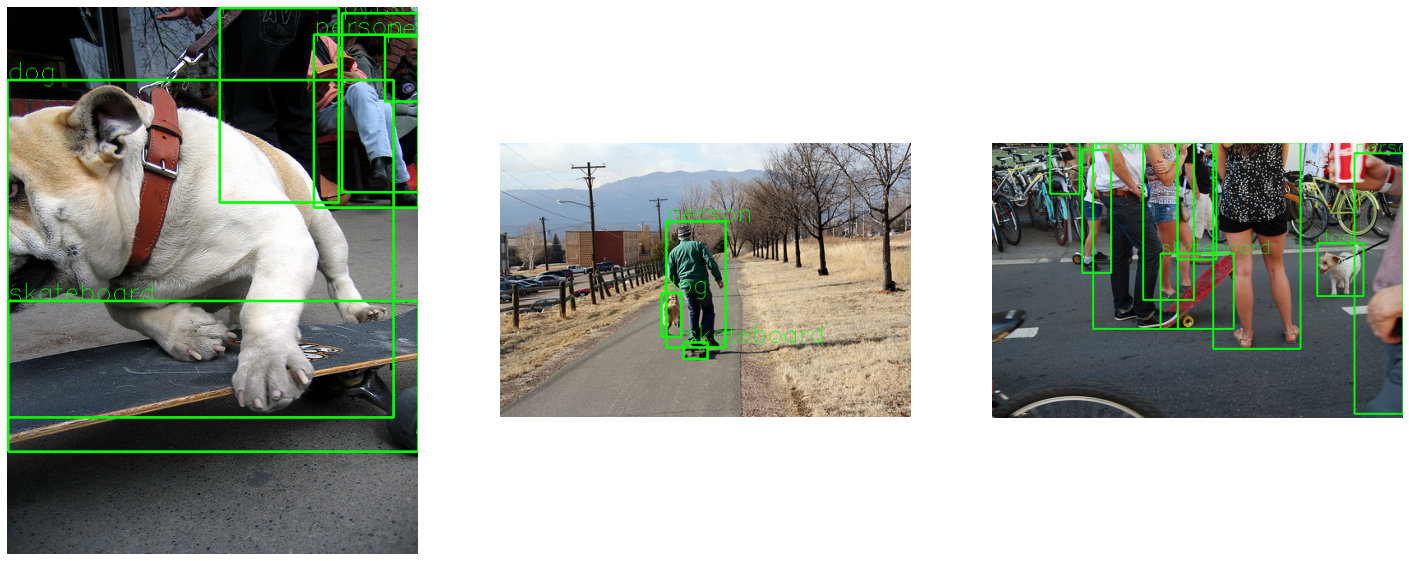

In [ ]:
boxed_imgs = []
for img in imgs:
  I = io.imread(img['coco_url'])
  img_id = img['id']
  anns = coco.loadAnns(coco.getAnnIds(img_id, example_cat_ids))
  cat_ids = [ann['category_id'] for ann in anns]
  labels = [example_categories[example_cat_ids.index(id)] for id in cat_ids]
  boxes = [ann['bbox'] for ann in anns]
  new_boxes = []
  for box in boxes:
    coord = [box[0], box[1], box[0]+box[2], box[1]+box[3]] #Convert co-ordinates from COCO format to that accepted by OpenCV
    coord = [int(item) for item in coord]
    new_boxes.append([(coord[0], coord[1]), (coord[2], coord[3])])

  for i,box in enumerate(new_boxes):
    cv2.rectangle(I, box[0], box[1], color=(0, 255, 0), thickness=2)
    cv2.putText(I, labels[i], box[0],  cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=1)

  boxed_imgs.append(I)

fig = plt.figure(figsize=(25,15))
for i,I in enumerate(boxed_imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.axis('off')
  plt.imshow(I)

<a name="fcnn"></a>
## Faster R-CNN model

The traditional approach to object detection was the sliding window approach. This approach involved moving a sliding window over the image. subsets of pixels from the window were sent to an image classifier. If the classifier could detect and object in the window, the bounding boxes were declared and the object was labelled. However, this is a computationaly intensive process.

However, with the advent of CNNs, researchers were more keen on developing methods for multi-class classification of objects, without the sliding window method. Rather, converting the task of identifying bounding boxes to a regression problem seemed more adept. Thus came Faster R-CNN. 

The method splits the image into regions. These regions are used for classifying the object class in that region. Also, a bounding box regressor determines the bounding box in that region.

In this tutorial, we will use Pytorch's implementation of Faster R-CNN to perform inference on images. Run the following cell to load the pre-trained model and set it to inference mode.

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval();

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


As our labels, we will use the instance category names as defined in the [Pytorch manual](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). These are the labels that the model has been trained on.

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

### Inference Pipeline

Let's build a pipeline that can perform inference on any given image. This would be convenient for visualising the results on any image of our choosing. 

In the cell below, we define a function get_prediction, that takes in the image url and a threshold for confidence score. It returns the bounding box co-ordinates predicted for the image along with their class labels.

In [ ]:
def get_prediction(img_url, threshold):
  img = io.imread(img_url) # Load image
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img) # Transform image into format accepted by the model class
  pred = model([img]) # Perform inference on the image
  pred_labels = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] 
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold] # Filter for boxes that have confidence score above threshold
  if not pred_t:
    return pred_boxes, pred_labels

  else:
    pred_t = pred_t[-1]

  pred_boxes = pred_boxes[:pred_t+1]
  pred_labels = pred_labels[:pred_t+1]
  return pred_boxes, pred_labels

In the following cell, we define a function get_objects, which accepts the image url, threshold and the categories of interest. It performs inference on the image and receives the bounding box co-ordinates. It then draws the bounding boxes and returns the final image.

In [ ]:
def get_objects(img_url, threshold=0.5, categories=None):

  boxes, pred_labels = get_prediction(img_url, threshold) # Perform inference
  if categories: # Filter for categories of interest
    boxes = [boxes[i] for i in range(len(boxes)) if pred_labels[i] in categories]
    pred_labels = [item for item in pred_labels if item in categories]

  img = io.imread(img_url)
  for i,box in enumerate(boxes): # Draw rectangles
    cv2.rectangle(img, box[0], box[1],color=(0, 255, 0), thickness=2)
    cv2.putText(img, pred_labels[i], box[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=1) 
  
  return img, boxes, pred_labels

### Visualising images

Now to test it out!

In the cell below, we've selected one of the previous images in the first line. You could run the cell to visualize results on this image. You could also use any image you wish by replacing the url in the first line with the url of your image. Also, if you uncomment lines 4 through 7, you could visualise a random image from the COCO dataset every time you run the cell. Feel free to play around with it!

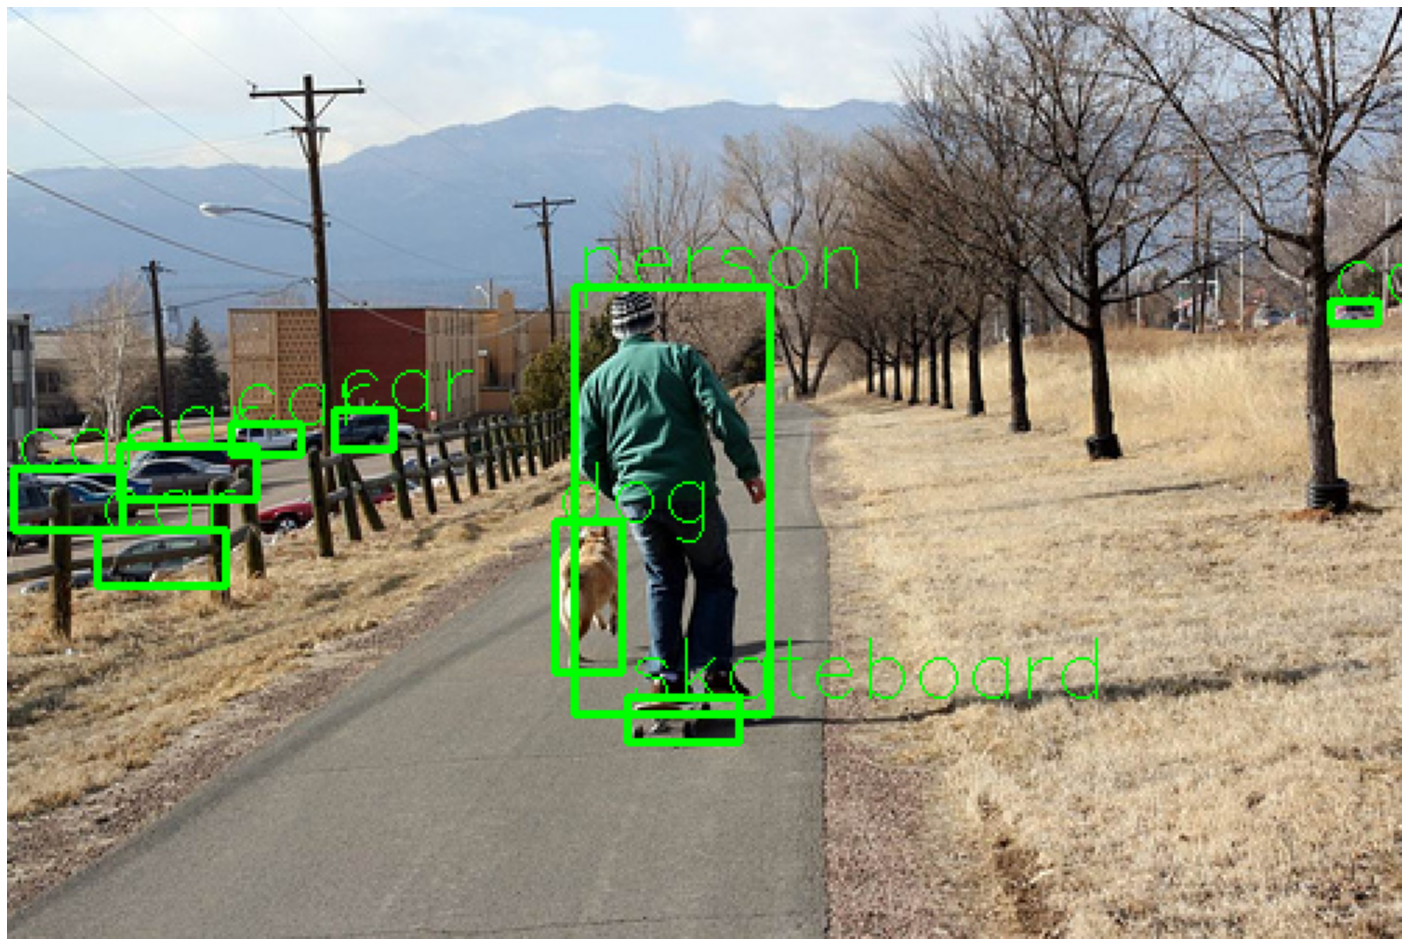

In [ ]:
img_url = 'http://images.cocodataset.org/val2017/000000324158.jpg'

# # Uncomment to infer to random images from the COCO dataset
# img_ids = coco.getImgIds()
# imgs = [coco.loadImgs(id) for id in img_ids]
# img_urls = [img[0]['coco_url'] for img in imgs]
# img_url = np.random.choice(img_urls)

boxed_img,_,_ = get_objects(img_url, threshold=0.8)

plt.figure(figsize=(25,20))
plt.axis('off')
plt.imshow(boxed_img)
plt.show()

<a name="example"></a>
## Example Application: Pedestrian Detection


It's no fun to visualise the COCO dataset alone. We want to be able to use our inference pipeline on other datasets as well. One such application is pedestrian detection, where you would like to identify pedestrians in an image and count the number of pedestrians. This could be used to monitor pedestrian traffic in an area and design policies likewise.

We introduce the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/) dataset. It is a well curated dataset of images of pedestrians, taken around the campuses of the University of Pennsylvania and Fudan University. It is well suited to the task of object detection and instance segmentation.

You can download the images in the dataset by running the following commands in the terminal.


```
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
unzip PennFudanPed.zip
```

Once downloaded, run the following cell to load the image paths for the dataset.


In [ ]:
img_dir = '/content/PennFudanPed/PNGImages'
img_filenames = os.listdir(img_dir)
img_paths = [os.path.join(img_dir, filename) for filename in img_filenames]

Now to test it out!

Run the following cell as many times as you like. Each time, it will pull a random image from the dataset and perform inference on it. It will also display the number of pedestrians in the image. This can be calculated by filtering for the pedestrian category in our API and counting the number of bounding boxes.

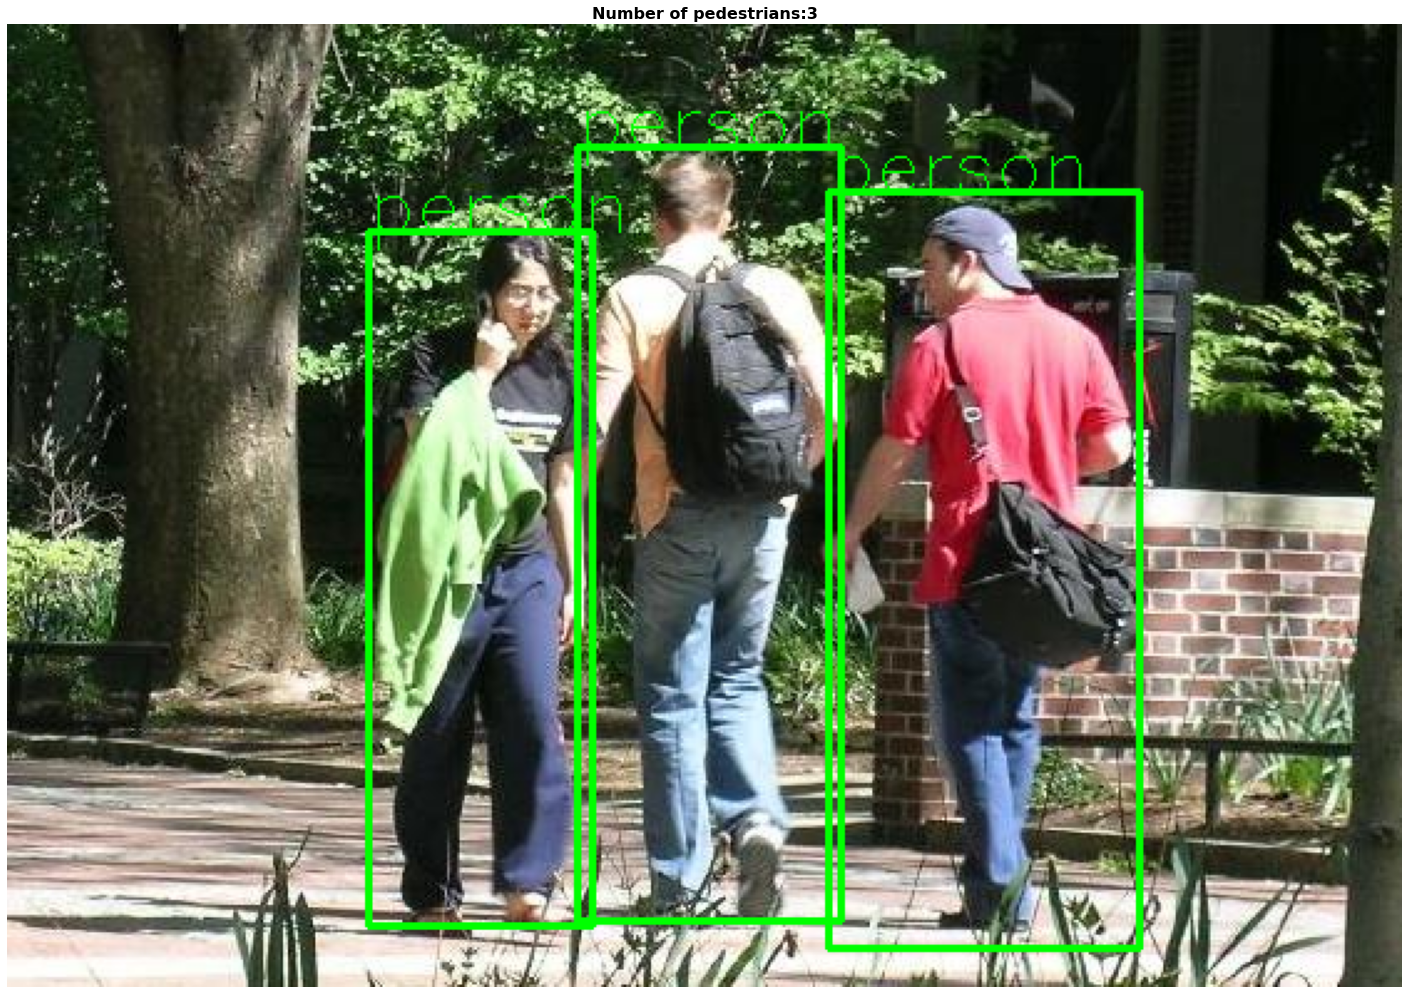

In [ ]:
img_path = np.random.choice(img_paths)
boxed_img, boxes, _ = get_objects(img_path, threshold=0.8, categories=['person'])
num_ped = len(boxes)

plt.figure(figsize=(25,20))
plt.axis('off')
plt.title('Number of pedestrians:{}'.format(num_ped), fontweight='bold', fontsize='16')
plt.imshow(boxed_img)
plt.show()

<a name="summ"></a>
## Summary and References

This tutorial introduces the Object Detection task and the COCO dataset and format. It also demonstrates how we could use pre-trained machine learning models to perform inference on our own datasets. These concepts could be explored more through these following resources:

1. COCO dataset: [https://cocodataset.org/#home](https://cocodataset.org/#home)
2. Torchvision object detection model zoo: [https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection)
3. OpenCV tutorial on object detection: [https://learnopencv.com/faster-r-cnn-object-detection-with-pytorch/](https://learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)
4. OpenCV API: [https://opencv.org/](https://opencv.org/)